In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, interact_manual, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [2]:
def sfun(x):
    return all([ ("Forsa Hartmoor" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [3]:
motor = fleet.iloc[3]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success;

In [4]:
e=Engine.from_fleet(mp,motor)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), frompickle=True, successtime=600)
fsm.run1(enforce=False, silent=True) # run Finite State Machine
fsm.store()
fsm.starts;

In [5]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}% starting Reliability in period")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 85, Successful: 65, Failed: 20 => 76.5% starting Reliability in period


In [6]:
rda[filterFSM.run2filter_content];

In [7]:
# %load_ext autoreload
# %aimport -pandas, -numpy
# %autoreload 2
# Execute FSM Run 2
#rda = fsm.run2(rda)
#fsm.store()

In [8]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,85.00,78.00,70.00,70.00,70.00,0.0,0.0,85.00,69.00,70.00,70.00,70.00
mean,113.23,21.74,4.88,19.21,132.87,NaN,NaN,266.09,6981.69,125.79,9.99,49.01
std,78.51,4.01,0.68,14.95,22.34,NaN,NaN,71.76,5944.33,11.11,0.02,0.33
min,4.84,3.23,4.04,1.11,37.42,NaN,NaN,4.84,4.04,36.58,9.90,48.25
25%,96.23,19.79,4.34,4.43,126.36,NaN,NaN,273.74,1822.12,127.31,9.99,48.76
50%,98.52,21.51,4.60,11.76,126.90,NaN,NaN,276.36,5422.36,127.39,9.99,48.95
75%,100.90,23.61,5.45,33.81,140.47,NaN,NaN,276.91,10822.75,127.51,10.00,49.26
max,489.45,44.01,6.37,42.48,219.22,NaN,NaN,489.45,20529.05,127.73,10.09,50.08


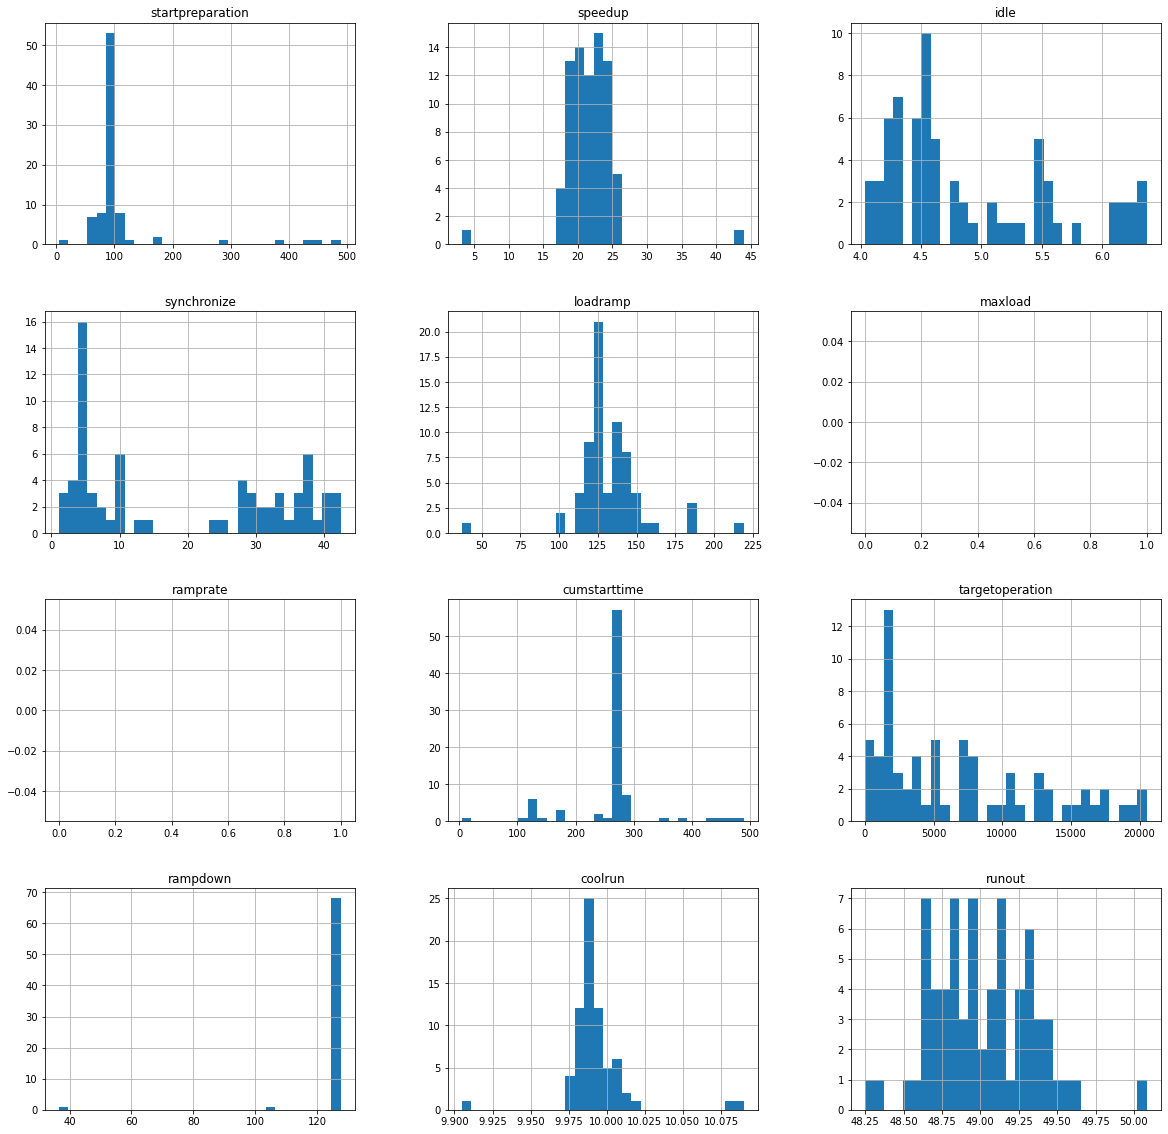

In [9]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2));

In [10]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (16,10)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [11]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    #{'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    #{'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]


In [12]:
def plot_with_additional_results(
        startversuch, 
        vset=None, 
        dset = [
        {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
        {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'}
    ]):

    if vset == None:
        vset = []
        for rec in dset:
            for d in rec['col']:
                vset.append(d) 
        vset = list(set(vset))

    data = get_cycle_data2(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=False, p_data=vset)
    fig = FSMPlot_Start(fsm, startversuch, data, vset, dset, figsize=dfigsize); 
    #fsm run 2 results
    #lcol='blue'
    # pl, _ = detect_edge_left(data, 'Power_PowerAct', startversuch)
    # pr, _ = detect_edge_right(data, 'Power_PowerAct', startversuch)
    # sl, _ = detect_edge_left(data, 'Various_Values_SpeedAct', startversuch)
    # sr, _ = detect_edge_right(data, 'Various_Values_SpeedAct', startversuch)
    # add_dbokeh_vlines([sl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    # add_dbokeh_vlines([sr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    # add_dbokeh_vlines([pl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    # add_dbokeh_vlines([pr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)

    #new_lines = [startversuch['starttime']] + [startversuch[k] for k in startversuch.keys() if k.endswith('_time')]
    #add_dbokeh_vlines(new_lines,fig,line_color='green', line_dash='solid', line_alpha=0.4)
    bokeh_show(fig)

In [13]:
def f(x=0):
    global v; v = x; 
    startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
    plot_with_additional_results(startversuch, vset, dset) 
interact_manual(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='40%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='40%'), max=84), Button(descript…

In [14]:
s = '''
<style>
    table, td, th {
        border: 1px solid grey;
        border-collapse: collapse;
        padding: 5px;
    }
    tfoot {
        text-align: left;
    }
</style>
'''
display(HTML(s + rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).to_html(escape=False, index=False, na_rep='', decimal='.')))

HTML(value='\n<style>\n    table, td, th {\n        border: 1px solid grey;\n        border-collapse: collapse…